<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/RL/DZ_3/DZ_3_pybullet_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Апостериорная оптимизация политики максимума распределения (DMPO)**

- https://notebook.community/deepmind/acme/examples/quickstart
- https://github.com/google-deepmind/acme/blob/master/examples/quickstart.ipynb




In [1]:
# @title Установка зависимостей
!apt-get update > /dev/null 2>&1
!apt-get -y install ffmpeg freeglut3-dev xvfb > /dev/null 2>&1  # For visualization.
!pip install imageio-ffmpeg --quiet

!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet
!pip install pybullet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [2]:
# @title Библеотеки
import os
import shutil
import matplotlib
import pybullet_envs

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/usr/local/lib/python3.10/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutil

# import `pybullet` locomotion environments

In [3]:
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv

import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


# Функции сохранения и восстановления контрольных точек

In [30]:
SAVE_DIR = "/content/drive/Othercomputers/My_comp/Документы/МФТИ_Наука_о_данных/RL_course/DZ_3/acme_ckpt_D4PG"

def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = SAVE_DIR
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = SAVE_DIR
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

# Функция для создания видеороликов


In [5]:
def display_video(frames, framerate=30):
  """
  Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

# Изменение базового класса среды

Вы можете начать изучение кода среды передвижения `pybullet` с этой точки входа, поднимаясь и опускаясь по иерархии классов: см. - https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py

Для наших экспериментов мы будем использовать среду передвижения `pybullet` с несколькими разными роботами (`Hopper`, `Ant`, `Humanoid` и т. д.). Чтобы роботы могли выполнять разные задачи, нам нужно изменить некоторые части кода среды. Это (в основном) будет означать изменение расчета вознаграждения среды в методе `step`.

В ячейке ниже мы приводим минимальный пример изменения класса среды `HopperBulletEnv`. Обычно для создания среды Hopper вам просто нужно создать экземпляр класса HopperBulletEnv:

```
env = HopperBulletEnv()
```
Однако, если вы проанализируете код среды, вы поймете, что вносить изменения (например, изменять расчет вознаграждения) таким образом сложно. Вместо этого полезно создать собственный дочерний класс, унаследованный от исходного класса `HopperBulletEnv`, и переопределить некоторые его методы. Это подклассирование позволит вам легко получить доступ к интересным частям класса среды для изменения.

В приведенном ниже примере пользовательского класса Hopper мы переопределяем несколько методов его родительского класса, чтобы (i) сделать расчет вознаграждения модифицируемым, (ii) добавить `step_counter`для обеспечения фиксированной продолжительности эпизода и (iii) сделать эпизод условия прекращения могут быть изменены. Обратите внимание, что в некоторых случаях переопределяющие методы по-прежнему вызывают свои родительские методы после выполнения необходимых модификаций (например, методы `__init__`, `reset`, `_isDone`). Напротив, метод `step` полностью переопределяется и не ссылается на свой родительский метод. Таким образом, вместо приведенной выше строки кода среда будет создана как:

```
env = Hopper()
```
Вы можете использовать этот подход и этот пример в качестве отправной точки вашего проекта. Во многих случаях этот пользовательский класс можно использовать как есть (только с изменением имени) с другими роботами в средах передвижения `pybullet`, наследуя от их соответствующих исходных классов среды, а не от `HopperBulletEnv`.

In [7]:
class Walker(Walker2DBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

     # если многопользовательская игра, действие сначала применяется ко всем роботам,
     # затем вызывается глобальный шаг(), затем _step() для всех роботов
     # с теми же действиями
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # также вычисляет self.joints_at_limit

    # state[0] — высота тела над землей, body_rpy[1] — шаг
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.1
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.1

    # предположим, что у нас есть двигатель постоянного тока с контроллером и торможение обратным током
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost,
                    joints_at_limit_cost, feet_collision_cost
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}

# Создание среды
После создания мы обертываем его «GymWrapper», чтобы сделать собственный интерфейс среды «Gym» совместимым с интерфейсом, используемым в библиотеке «dm-acme», которая представляет собой пакет обучения с подкреплением, который мы будем использовать.

dm-acme - https://github.com/deepmind/dm_env.

In [26]:
env = Walker(render=False)

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Определяет форму и размеры действия.
env_spec = specs.make_environment_spec(env)  # Характеристики окружающей среды.

In [27]:
# Координаты x и y целевого местоположения.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


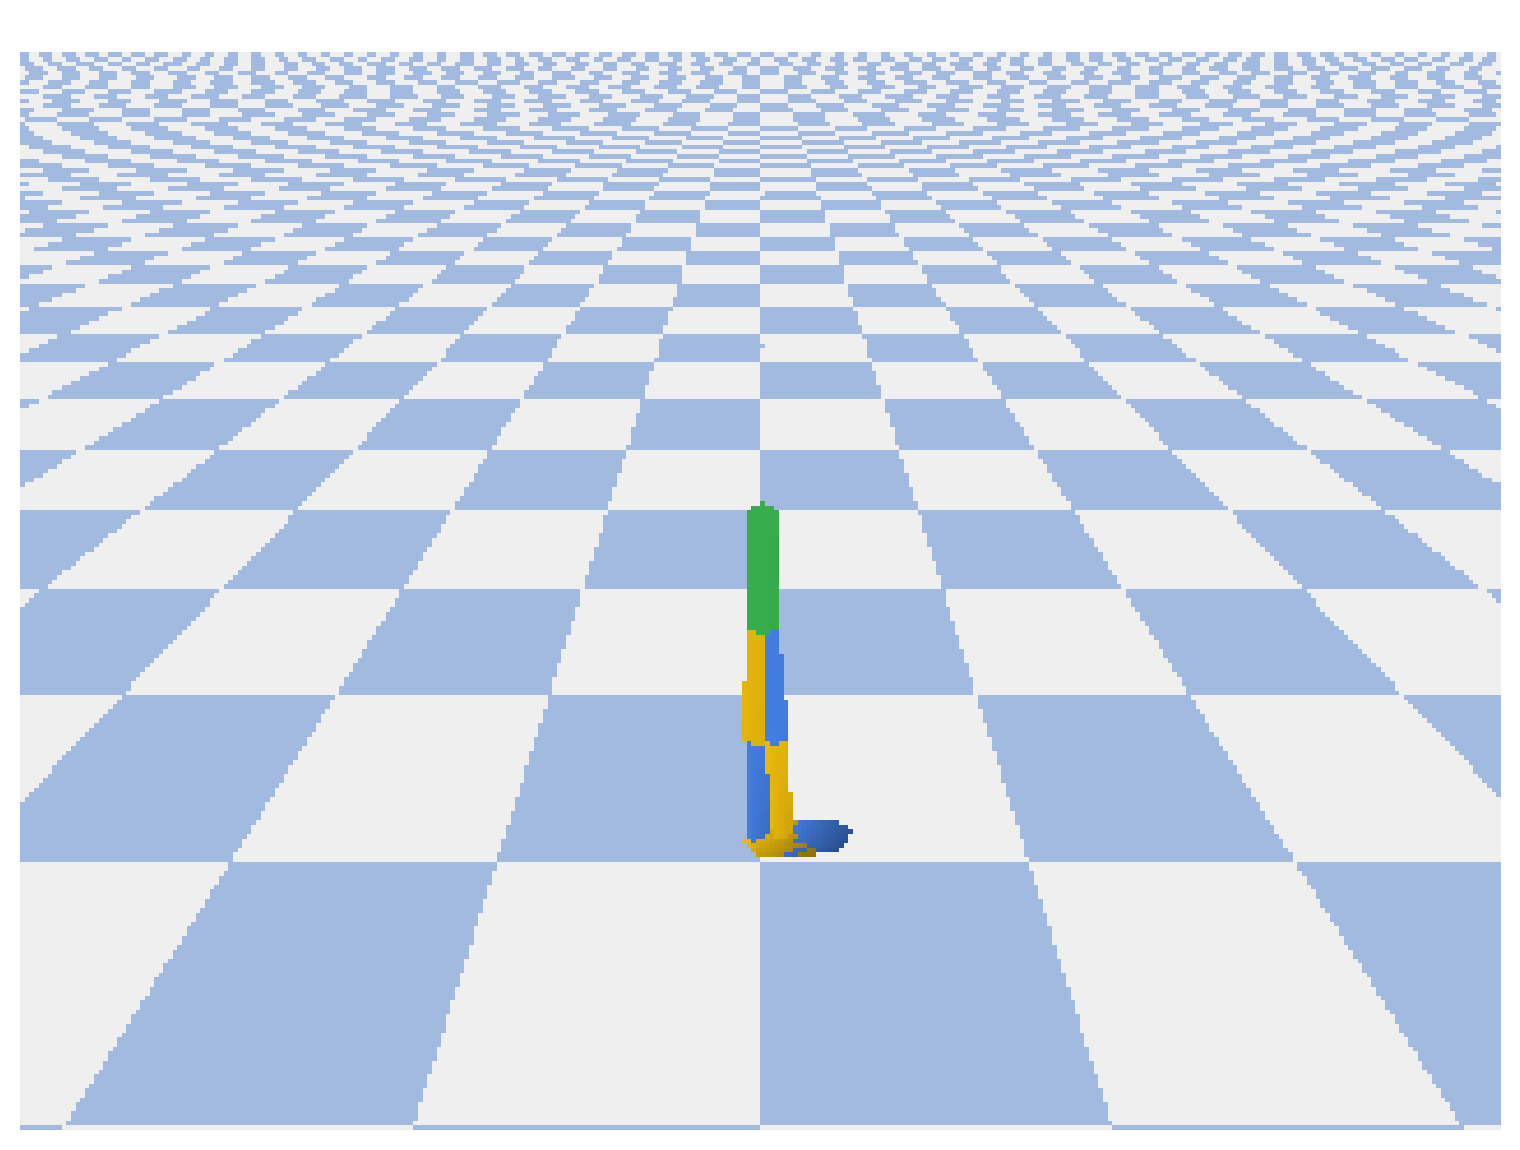

In [10]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

## Запуск среды случайными действиями

Мы еще не обучили политику, но все равно можем увидеть среду в действии, передав ей случайную управляющую последовательность.

In [45]:
# Запустите env на n_steps, примените случайные действия и покажите видео.
n_steps = 500

frames = []
timestep = env.reset()
for i in range(n_steps):
  # Произвольное управление исполнительными механизмами.
  action = np.random.randn(action_spec.shape[0])
  if i:
    action = 2*np.sin(action) + last_action

  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))
  last_action = action

display_video(frames, framerate=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [50]:
# Запустите env на n_steps, примените случайные действия и покажите видео.
n_steps = 500

frames = []
timestep = env.reset()
for i in range(n_steps):
  # Произвольное управление исполнительными механизмами.
  action = np.random.uniform(action_spec.minimum,
                            action_spec.maximum,
                            size=action_spec.shape)
  if i:
    action = last_action + np.sin(action) + 0.2*np.sin(action)**2 + 0.02*np.sin(action)**3

  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))
  last_action = action

display_video(frames, framerate=20)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [95]:
# Запустите env на n_steps, примените случайные действия и покажите видео.
n_steps = 200

frames = []
timestep = env.reset()
for i in range(n_steps):
  # Произвольное управление исполнительными механизмами.
  action = np.random.uniform(action_spec.minimum,
                            action_spec.maximum,
                            size=action_spec.shape)
  if i:
    action = last_action + 0.5*np.sin(action)*(-1)**i + 0.2*(-1)**(i+1)*np.sin(action)**2 + 0.02*(-1)**i*np.sin(action)**3

  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))
  last_action = action

display_video(frames, framerate=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [12]:
# Давайте посмотрим на некоторые другие свойства среды.
# Обратите внимание на формы и ограничения мин/макс.

print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

Actions:
 BoundedArray(shape=(6,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1.])
Observations:
 BoundedArray(shape=(22,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## некоторые свойства робота

Давайте рассмотрим (декартовы) координаты различных частей тела робота и его скорость. Обратите внимание, что robot — это атрибут класса env. Также обратите внимание, как осуществляется доступ к частям тела, поскольку это может понадобиться вам для настройки расчета вознаграждения в вашем проекте.

In [13]:
# Декартовы координаты частей тела.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [0.90153208 0.         0.        ]
torso      [-0.01668957  0.          1.13801509]
link0_3    [0.90153208 0.         0.28985885]
link0_4    [0.90153208 0.         0.28985885]
link0_6    [0.13022593 0.         1.00231006]
thigh      [0.00992743 0.         0.81216997]
link0_8    [-0.11037108  0.          0.62202988]
leg        [-0.24403296  0.          0.41076108]
link0_10   [-0.37769485  0.          0.19949228]
foot       [-0.28118492  0.          0.2256807 ]
link0_12   [0.13022593 0.         1.00231006]
thigh_left [0.10177055 0.         0.7791167 ]
link0_14   [0.07331516 0.         0.55592335]
leg_left   [0.04204214 0.         0.30788705]
link0_16   [0.01076911 0.         0.05985076]
foot_left  [0.08976334 0.         0.12116888]
floor      [0. 0. 0.]


In [14]:
# Декартовы компоненты скорости робота.
env.robot_body.speed()

array([-0.17923775,  0.        , -0.75806938])